In [1]:
import os

import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
attackers = list(ATTACKERS)
attackers

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


['well-informed', 'informed', 'round-robin', 'random']

In [4]:
# Two blank lines added to please `flakehell lint`


class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        return [0 for _ in observations], [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass

no_action = rllib.agents.trainer_template.build_trainer(name='NoAction', default_policy=NoAction)

In [5]:
if os.path.isdir('/var/run/secrets/kubernetes.io'):  # inside k8s pod
    args = dict(address='auto')
else:  # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

init(**args)

2021-09-14 09:33:28,156	INFO worker.py:825 -- Connecting to existing Ray cluster at address: 10.28.1.6:6379


{'node_ip_address': '10.28.1.6',
 'raylet_ip_address': '10.28.1.6',
 'redis_address': '10.28.1.6:6379',
 'object_store_address': '/tmp/ray/session_2021-09-12_16-41-31_310948_162/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-12_16-41-31_310948_162/sockets/raylet',
 'webui_url': '10.28.1.6:8265',
 'session_dir': '/tmp/ray/session_2021-09-12_16-41-31_310948_162',
 'metrics_export_port': 64446,
 'node_id': '687f7a23a7c323c217e31b16c9fc75cf57b191b2dfbafb8524d0ad70'}

In [6]:
config = dict(
    framework='torch',
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs), attacker=tune.grid_search(attackers)),
    seed=tune.grid_search([0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]),
    # evaluation ONLY: avoid MultiGPU optimizer, set all relevant sizes to 0
    simple_optimizer=True,
    num_workers=0,
    train_batch_size=0,
    rollout_fragment_length=0,
    timesteps_per_iteration=0,
    # define evaluation settings
    evaluation_interval=1,
    evaluation_num_workers=8,
    evaluation_config=dict(explore=False),
    evaluation_num_episodes=5,  # run 5 episodes on the same environment
)

In [7]:
results = tune.run(
    no_action,
    config=config,
    stop=dict(training_iteration=0),
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
)

Trial name,status,loc,env_config/attack_graph,env_config/attacker,seed,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
NoAction_AttackSimulationEnv_d135a_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",well-informed,0,1,1.37873,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",well-informed,0,1,1.42152,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",well-informed,0,1,2.98938,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00003,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",well-informed,0,1,1.64061,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00004,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",well-informed,0,1,1.41749,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00005,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",well-informed,0,1,2.17049,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00006,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",well-informed,0,1,5.71954,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00007,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",informed,0,1,0.303379,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00008,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",informed,0,1,1.25884,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_d135a_00009,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",informed,0,1,2.41062,0,nan,nan,nan,nan


2021-09-14 10:25:38,495	INFO tune.py:561 -- Total run time: 3130.14 seconds (3129.05 seconds for the tuning loop).


In [8]:
shutdown()

In [9]:
rename = {
    'config.env_config.attack_graph': 'graph',
    'config.env_config.attacker': 'Attacker',
    'evaluation.hist_stats.episode_reward': 'returns',
    'evaluation.hist_stats.episode_lengths': 'lengths',
}

df = results.results_df[rename.keys()].rename(columns=rename)
df['Graph size'] = df['graph'].apply(lambda g: g.num_attacks)
del df['graph']
df['tuple'] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis='columns')
del df['returns']
del df['lengths']
df = df.explode('tuple', ignore_index=True)
df[['Returns', 'Episode lengths']] = df['tuple'].tolist()
del df['tuple']
df

,Attacker,Graph size,Returns,Episode lengths
0,well-informed,7,-1132.0,146.0
1,well-informed,7,-3350.0,56.0
2,well-informed,7,-9069.0,73.0
3,well-informed,7,-22387.0,99.0
4,well-informed,7,-3668.0,17.0
...,...,...,...,...
2235,random,78,-82173.0,687.0
2236,random,78,-148485.0,936.0
2237,random,78,-141101.0,1406.0
2238,random,78,-144201.0,1029.0


In [10]:
sns.set(style='darkgrid', rc={'figure.figsize': (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

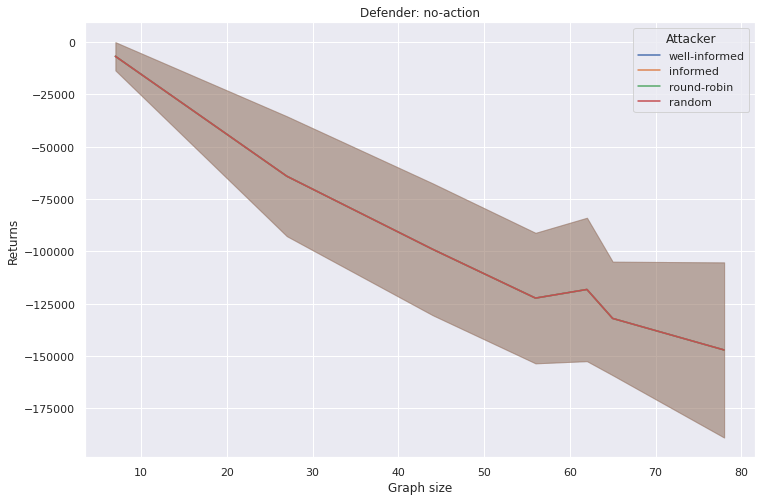

In [11]:
g = sns.lineplot(data=df, x='Graph size', y='Returns', hue='Attacker', ci='sd')
g.legend(title='Attacker', loc='upper right')
g.set_title('Defender: no-action')

Text(0.5, 1.0, 'Defender: no-action')

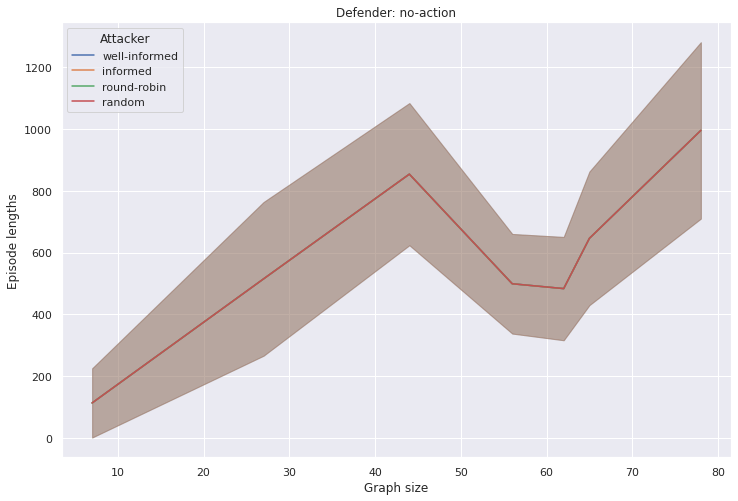

In [12]:
g = sns.lineplot(data=df, x='Graph size', y='Episode lengths', hue='Attacker', ci='sd')
g.legend(title='Attacker', loc='upper left')
g.set_title('Defender: no-action')

In [13]:
df.groupby('Attacker').describe()

Graph size                                                     \
                   count       mean        std  min   25%   50%   75%   max   
Attacker                                                                      
informed           560.0  48.428571  22.653063  7.0  27.0  56.0  65.0  78.0   
random             560.0  48.428571  22.653063  7.0  27.0  56.0  65.0  78.0   
round-robin        560.0  48.428571  22.653063  7.0  27.0  56.0  65.0  78.0   
well-informed      560.0  48.428571  22.653063  7.0  27.0  56.0  65.0  78.0   

              Returns                ...                 Episode lengths  \
                count          mean  ...      75%    max           count   
Attacker                             ...                                   
informed        560.0 -98478.198214  ... -61377.0 -289.0           560.0   
random          560.0 -98478.198214  ... -61377.0 -289.0           560.0   
round-robin     560.0 -98478.198214  ... -61377.0 -289.0           560.0   
well-informed   560.0 -98478.198214  ... -61377.0 -289.0           560.0   

                                                                          
                     mean         std   min    25%    50%    75%     max  
Attacker                                                                  
informed       586.707143  337.726657  16.0  381.0  536.5  793.0  1622.0  
random         586.707143  337.726657  16.0  381.0  536.5  793.0  1622.0  
round-robin    586.707143  337.726657  16.0  381.0  536.5  793.0  1622.0  
well-informed  586.707143  337.726657  16.0  381.0  536.5  793.0  1622.0  

[4 rows x 24 columns]